# The Cinematic Nexus: Unveiling the Future of Movie Recommendations and Analysis

by Anthony Amadasun

## 1.2 Data Modeling 

---

### 1.2.1 Introduction




In this section, the project will delve into the process of transforming and engineering the data for our movie recommendation system. Additionally, we will build and evaluate predictive models and employ data visualization techniques to gain insights into the performance and characteristics of the models.

---

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack

#sklearn import
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

#nltk import
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

#gensim imports
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import string
import json


In [2]:
tmdb_df = pd.read_csv('../data/tmdb_data.csv')

In [3]:
tmdb_df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,...,vote_average,vote_count,directors,cast,popularity_normalized,vote_count_normalized,vote_average_normalized,genre_names,release_year,genre_ids_str
0,False,/4MCKNAc6AbWjEsM2h9Xc29owo4z.jpg,"[28, 53, 18]",866398,en,The Beekeeper,One man’s campaign for vengeance takes on nati...,3775.726,/A7EByudX0eOzlkQ2FIbogzyazm2.jpg,2024-01-10,...,7.252,881,David Ayer,"Jason Statham, Emmy Raver-Lampman, Bobby Nader...",1.000000,0.025019,0.7252,"['Action', 'Thriller', 'Drama']",2024.0,"['Action', 'Thriller', 'Drama']"
1,False,/pWsD91G2R1Da3AKM3ymr3UoIfRb.jpg,"[28, 878, 18]",933131,ko,황야,After a deadly earthquake turns Seoul into a l...,1734.954,/zVMyvNowgbsBAL6O6esWfRpAcOb.jpg,2024-01-26,...,6.794,245,Heo Myeong-haeng,"Ma Dong-seok, Lee Hee-jun, Lee Jun-young, Roh ...",0.455400,0.006958,0.6794,"['Action', 'Science Fiction', 'Drama']",2024.0,"['Action', 'Science Fiction', 'Drama']"
2,False,/criPrxkTggCra1jch49jsiSeXo1.jpg,"[878, 12, 28]",609681,en,The Marvels,"Carol Danvers, aka Captain Marvel, has reclaim...",1362.364,/9GBhzXMFjgcZ3FdR9w3bUMMTps5.jpg,2023-11-08,...,6.331,1485,Nia DaCosta,"Brie Larson, Teyonah Parris, Iman Vellani, Zaw...",0.355971,0.042172,0.6331,"['Science Fiction', 'Adventure', 'Action']",2023.0,"['Science Fiction', 'Adventure', 'Action']"
3,False,/yyFc8Iclt2jxPmLztbP617xXllT.jpg,"[35, 10751, 14]",787699,en,Wonka,Willy Wonka – chock-full of ideas and determin...,1340.068,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,2023-12-06,...,7.208,1955,Paul King,"Timothée Chalamet, Calah Lane, Keegan-Michael ...",0.350021,0.055519,0.7208,"['Comedy', 'Family', 'Fantasy']",2023.0,"['Comedy', 'Family', 'Fantasy']"
4,False,/cnqwv5Uz3UW5f086IWbQKr3ksJr.jpg,"[28, 12, 14]",572802,en,Aquaman and the Lost Kingdom,Black Manta seeks revenge on Aquaman for his f...,993.425,/7lTnXOy0iNtBAdRP3TZvaKJ77F6.jpg,2023-12-20,...,6.950,1510,James Wan,"Jason Momoa, Patrick Wilson, Yahya Abdul-Matee...",0.257516,0.042882,0.6950,"['Action', 'Adventure', 'Fantasy']",2023.0,"['Action', 'Adventure', 'Fantasy']"


### 1.2.2 Data Transformation/Engineering

**Deliverables:**
- Feature Engineering: Create new features that might enhance the predictive power of the models, such as extracting information from actors amd directors.
- Handle Sparse Data: Address potential sparsity issues in user-item interaction matrices, as sparse data can impact collaborative filtering models.
- Encoding: Encode categorical features, ensuring all data is in a format suitable for modeling.

---

**Feature Engineering**

Create columns that looks at the influences of lead actors/actress and Director popularity

In [4]:
# Define a function to extract the lead actor from the comma-separated list
def extract_lead_actor(x):
    try:
        if not pd.isna(x): #Check if the value is non NaN
            cast_list = x.split(', ')
            return cast_list[0] if cast_list else None
        else:
            return None
    except Exception as e:
        print(f"Error extracting lead actor: {e}")
        return None

# Apply the function to create the lead_actor column
tmdb_df['lead_actor'] = tmdb_df['cast'].apply(extract_lead_actor)

# Calculate the average user rating for movies featuring each lead actor
actor_avg_rating = tmdb_df.groupby('lead_actor')['vote_average'].mean().reset_index()
actor_avg_rating.rename(columns={'vote_average': 'lead_actor_avg_rating'}, inplace=True)

# Merge the actor average ratings back to df
tmdb_df = pd.merge(tmdb_df, actor_avg_rating, how='left', on='lead_actor')


In [5]:
def extract_director(x):
    try:
        if pd.notna(x):  # Check if the value is not NaN
            directors_list = json.loads(x)
            if directors_list:
                return directors_list[0]['name']
    except (json.JSONDecodeError, KeyError, IndexError):
        pass  # Handle errors by returning None or any default value
    return None


In [6]:
# Create the single director column by extracting the first director name
tmdb_df['director'] = tmdb_df['directors'].apply(lambda x: x.split(',')[0] if pd.notna(x) else None)

# Calculate the average user rating for movies directed by each director
director_avg_rating = tmdb_df.groupby('director')['vote_average'].mean().reset_index()
director_avg_rating.rename(columns={'vote_average': 'director_avg_rating'}, inplace=True)

# Merge the director average ratings to df
tmdb_df = pd.merge(tmdb_df, director_avg_rating, how='left', on='director')


**Handling Sparse Data and Encoding**

In [7]:
# Convert the genre_ids_str column to a list of lists
tmdb_df['genre_ids_str'] = tmdb_df['genre_ids_str'].apply(eval)

In [8]:
# Use MultiLabelBinarizer to one-hot encode the genre_ids_str column
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(tmdb_df['genre_ids_str']), columns=mlb.classes_, index=tmdb_df.index)

In [9]:
# Concatenate the one-hot encoded genres with the original DataFrame
tmdb_df = pd.concat([tmdb_df, genre_encoded], axis=1)

In [10]:
# Drop the original genre_ids_str column
tmdb_df = tmdb_df.drop('genre_ids_str', axis=1)

In [11]:
# Preparing data for building a recommendation system 
# by handling sparsity and creating a sparse matrix for 
# Collaborative filtering methods
interaction_data = tmdb_df[['popularity_normalized', 'vote_average_normalized', 
                            'vote_count_normalized', 'release_year', 'lead_actor_avg_rating',
                           'director_avg_rating'] + list(mlb.classes_)]

In [12]:
interaction_data.dtypes

popularity_normalized      float64
vote_average_normalized    float64
vote_count_normalized      float64
release_year               float64
lead_actor_avg_rating      float64
director_avg_rating        float64
Action                       int64
Adventure                    int64
Animation                    int64
Comedy                       int64
Crime                        int64
Documentary                  int64
Drama                        int64
Family                       int64
Fantasy                      int64
History                      int64
Horror                       int64
Music                        int64
Mystery                      int64
Romance                      int64
Science Fiction              int64
TV Movie                     int64
Thriller                     int64
War                          int64
Western                      int64
dtype: object

In [13]:
# columns in the interaction_data_pivot
interaction_data_columns = ['director_avg_rating', 'lead_actor_avg_rating', 'popularity_normalized', 'vote_average_normalized', 'vote_count_normalized', 'release_year', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']

# title as index and  the desired columns
interaction_data_pivot = tmdb_df.set_index('title')[interaction_data_columns]

interaction_data_pivot.head()


,director_avg_rating,lead_actor_avg_rating,popularity_normalized,vote_average_normalized,vote_count_normalized,release_year,Action,Adventure,Animation,Comedy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,,
The Beekeeper,6.895333,6.525095,1.000000,0.7252,0.025019,2024.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Badland Hunters,6.794000,7.219714,0.455400,0.6794,0.006958,2024.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
The Marvels,6.181000,5.987000,0.355971,0.6331,0.042172,2023.0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
Wonka,7.336000,6.061600,0.350021,0.7208,0.055519,2023.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Aquaman and the Lost Kingdom,7.016300,6.399200,0.257516,0.6950,0.042882,2023.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Handling Sparse Data: Replace NaN values with 0
interaction_matrix = interaction_data.fillna(0)

In [15]:
#convert into sparse matrix using csr_matrix
sparse_interaction_matrix = csr_matrix(interaction_matrix.values)

In [16]:
# Calculate cosine similarity using sparse matrix
sparse_distances = pairwise_distances(sparse_interaction_matrix, metric='cosine')
sparse_cosine_similarities = 1.0 - sparse_distances


### 1.2.3 Data Modeling


**Deliverables:**

- Collaborative Filtering: Implement collaborative filtering techniques to make movie recommendations based on user preferences and similarities between users or items.
- Content-Based Filtering: Apply content-based filtering approaches to recommend movies based on their features, such as overview, cast, or director and nlp technique.
- K-Means model: Apply content-based genre clustering for improved recommendation accuracy.

---

**Collaborative Filtering**

- Created an interaction matrix 
- Apply collaborative filtering using cosine similarity on interaction_data_pivot
- item_similarity_matrix will then be used to recommend movies for a given input movie using the get_movie_recommendations function.
- create an iteractive recommendation function that allow users to input their favorite movie and receive recommendations based on their preferences.

In [17]:
def recommend_based_on_user_preference(user_preference, tmdb_df):
    # Split user input
    preferences = [preference.strip() for preference in user_preference.split(',')]

    # Filter movies based on user preferences in directors and cast columns
    filtered_movies = tmdb_df[
        tmdb_df['directors'].apply(lambda x: any(pref.lower() in str(x).lower() for pref in preferences)) |
        tmdb_df['cast'].apply(lambda x: any(pref.lower() in str(x).lower() for pref in preferences))
    ]

    # Sort movies by popularity (can change for other metric)
    sorted_movies = filtered_movies.sort_values(by='popularity_normalized', ascending=False)

    # Extract recommended movie titles
    recommended_movies = sorted_movies['title'].tolist()

    return recommended_movies


In [18]:
item_similarity = cosine_similarity(sparse_interaction_matrix.T, dense_output=False)
# interaction_data_pivot is user interaction data
item_similarity_matrix = cosine_similarity(interaction_data_pivot.fillna(0))

# Function to get movie recommendations based on item similarity
def get_movie_recommendations(movie_title, item_similarity_matrix, interaction_data_pivot):
    """
    This function takes a movie title, an item similarity matrix, and a interaction_data_pivot as input.
    It returns a list of movie recommendations based on the item similarity of the input movie.
    
    - movie_title (str): The title of the movie for which recommendations are requested.
    - item_similarity_matrix (numpy.ndarray): The item similarity matrix, computed using collaborative filtering
      (e.g., cosine similarity on the interaction_data_pivot ).
    - interaction_data_pivot (pd.DataFrame): The user-item interaction matrix where rows represent movies, and columns represent various features
      like 'director_avg_rating', 'lead_actor_avg_rating', 'popularity_normalized', 'vote_average_normalized', 'vote_count_normalized', 'release_year', and genre indicators.
      The values represent movie features or characteristics.
    
    Returns:
    List[str]: A list of recommended movies based on item similarity. 
    The list is sorted in descending order of similarity.
      
    """
    if movie_title in interaction_data_pivot.index:
        similar_scores = item_similarity_matrix[interaction_data_pivot.index.get_loc(movie_title)]
        similar_movies = list(interaction_data_pivot.index[np.argsort(similar_scores)[::-1]])
        return similar_movies[1:]  # Exclude the input movie itself
    else:
        print(f"Movie '{movie_title}' not found in the dataset.")
        user_preference = input("Enter your preferred actor, genre, or other relevant information: ")
        # Perform recommendation based on user's additional input
        recommendations = recommend_based_on_user_preference(user_preference, tmdb_df)
        return recommendations


In [19]:
def interactive_movie_recommendation(tmdb_df):
    """
    This function allows users to input their favorite movie and receive recommendations
    based on their preferences,including genre, director, actor/actress, and release year range.
    
    Parameters:
    - tmdb_df (pd.DataFrame): DataFrame containing movie data, including columns like 'title', 'genre_names', 'directors',
    'cast', 'release_year', 'popularity_normalized', and others.
    
    Returns:
    None
    
    Note: The function utlizes the 'get_movie_recommendations' function, and the 'item_similarity_matrix' computed
    using collaborative filtering (e.g., cosine similarity on the item interaction matrix).
    
    Example usage:
    interactive_movie_recommendation(tmdb_df)
    """
    while True:
        # Prompt the user to enter their favorite movie
        user_input_movie = input("Enter your favorite movie: ")

        # Check if the movie exists in the dataset
        matching_movies = tmdb_df[tmdb_df['title'].str.lower() == user_input_movie.lower()]

        if not matching_movies.empty:
            # If the movie is found, recommend similar movies
            recommended_movies = get_movie_recommendations(user_input_movie, item_similarity_matrix, interaction_data_pivot)
            print(f"\nHere are some recommendations based on '{user_input_movie}':")
            print(recommended_movies[:5])
        else:
            print(f"Movie '{user_input_movie}' not found in the dataset.")
            print("Let's try to find recommendations based on your preferences.")

            while True:
                # Prompt the user for their favorite genre, director, or actor/actress
                user_preference = input("Enter your favorite genre, director, or actor/actress: ")

                # Prompt the user for the desired release year range
                start_year = int(input("Enter the starting year: "))
                end_year = int(input("Enter the ending year: "))

                # Filter movies based on user preferences and release year range
                filtered_movies = tmdb_df[
                    (tmdb_df['genre_names'].apply(lambda x: user_preference.lower() in str(x).lower())) |
                    (tmdb_df['directors'].apply(lambda x: user_preference.lower() in str(x).lower())) |
                    (tmdb_df['cast'].apply(lambda x: user_preference.lower() in str(x).lower())) &
                    (tmdb_df['release_year'].between(start_year, end_year))
                ]
                print("Filtered Movies:")
                print(filtered_movies[['title', 'release_year']])


                # Sort movies by popularity
                sorted_movies = filtered_movies.sort_values(by='popularity_normalized', ascending=False)

                # Extract recommended movie titles
                recommended_movies = sorted_movies['title'].tolist()

                if not recommended_movies:
                    print("No movies found based on your preferences.")
                    break

                print(f"\nHere are some recommendations based on your preferences:")
                print(recommended_movies[:5])

                # user feedback
                user_feedback = input("Do these movies appeal to you? (yes/no): ").lower()

                if user_feedback == 'yes':
                    print("Great! Enjoy watching.")
                    return
                elif user_feedback == 'no':
                    print("Let's try refining your preferences.")
                    continue
                else:
                    print("Invalid input. Please enter 'yes' or 'no'.")
                    continue

        #user feedback
        user_feedback = input("Do these movies appeal to you? (yes/no): ").lower()

        if user_feedback == 'yes':
            print("Great! Enjoy watching.")
            break
        elif user_feedback == 'no':
            print("Sorry to hear that. Let's try refining your preferences.")
            continue
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")
            continue


In [20]:
# resulting interaction prompt
interactive_movie_recommendation(tmdb_df)

Enter your favorite movie:  star wars


Movie 'star wars' not found in the dataset.


Enter your preferred actor, genre, or other relevant information:  george lucas



Here are some recommendations based on 'star wars':
['Star Wars', 'Men in Black', 'Indiana Jones and the Temple of Doom', 'Star Wars: Episode I - The Phantom Menace', 'Star Wars: Episode III - Revenge of the Sith']


Do these movies appeal to you? (yes/no):  yes


Great! Enjoy watching.


In [21]:
american_graffiti_release_year = tmdb_df.loc[tmdb_df['title'] == 'American Graffiti', 'release_year']
print(american_graffiti_release_year)


2376    1973.0
Name: release_year, dtype: float64


**Content Based Filtering**

<ins>Text preprocessing step:</ins> 
- Lowercasing: Convert all text to lowercase to ensure consistency.
- Tokenization: Break down the text into individual words or tokens.
- Removing Stopwords: Exclude common words that don't carry much meaning (e.g., "the," "and," "is").
- Removing Punctuation and Special Characters: Keep only alphanumeric characters and relevant symbols.
- Stemming or Lemmatization: Reduce words to their base or root form for better feature representation.

<ins>Feature Extraction:</ins>
-  convert the text into numerical features (TF-IDF or Cvec)
- combined features 
- calculated similarity
- implement a function to get similar movies based on a given movie title.

In [22]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aamad_000/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aamad_000/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/aamad_000/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
#functions for text preprocessing 
#
def preprocess_text(text):
    #lowcasing
    text = text.lower()
    
    #tokenization
    tokens = word_tokenize(text)
    
    #removing stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    
    #Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    
    if pd.isnull(text):  # Check for NaN values
        return ''
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)


In [24]:
# overview_example = "In a GALAXY far, far away..."
# preprocessed_overview = lemmatize_text(overview_example)
# print(preprocessed_overview)

**convert text to numeric features**

In [25]:
tmdb_df['preprocessed_overview'] = tmdb_df['overview'].apply(lemmatize_text)

In [26]:
def apply_tfidf_vectorizer(data, text_column='preprocessed_overview'):
    """
    Apply TfidfVectorizer to convert preprocessed text data in the specified column of the dataframe to a TF-IDF matrix.
    
    Parameters:
    - data (pd.DataFrame): The input dataframe containing the column with preprocessed text data.
    - text_column (str): The name of the column containing preprocessed text data. Default is 'preprocessed_overview'.
    
    Returns:
    - tuple: A tuple showing the shape of the resulting TF-IDF matrix.
    """
    # Extract the preprocessed text data
    text_data = data[text_column].astype(str)
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit and transform the preprocessed text data to TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    
    #feature_names = tfidf_vectorizer.get_feature_names_out()
    
    return tfidf_matrix, tfidf_vectorizer




In [27]:
def combine_features(data, tfidf_matrix):
    """
    Combine TF-IDF matrix with one-hot encoded categorical features.

    Parameters:
    - data (pd.DataFrame): The input dataframe containing the necessary columns.
    - tfidf_matrix (scipy.sparse.csr_matrix): The TF-IDF matrix obtained from preprocessed text data.

    Returns:
    - combined_matrix (scipy.sparse.csr_matrix): The combined matrix of TF-IDF and one-hot encoded categorical features.
    """
    # One-Hot Encoding for categorical features like cast and director
    categorical_features = ['cast', 'director', 'release_year']
    one_hot_encoder = OneHotEncoder()
    categorical_matrix = one_hot_encoder.fit_transform(data[categorical_features])

    # Combine TF-IDF matrix with the one-hot encoded categorical matrix
    combined_matrix = hstack([tfidf_matrix, categorical_matrix])

    return combined_matrix



In [28]:
tfidf_matrix, tfidf_vectorizer = apply_tfidf_vectorizer(tmdb_df)

In [29]:
# Combine features
combined_features_matrix = combine_features(tmdb_df, tfidf_matrix)

In [30]:
combined_features_matrix.shape

(3000, 16655)

**calculate similarity**

In [31]:
def calculate_similarity(feature_matrix):
    """
    Calculate cosine similarity between movies based on their feature matrix.

    Parameters:
    - feature_matrix (scipy.sparse.csr_matrix): The feature matrix containing TF-IDF and other features.

    Returns:
    - similarity_matrix (numpy.ndarray): The cosine similarity matrix.
    """
    similarity_matrix = cosine_similarity(feature_matrix, dense_output=False)
    return similarity_matrix


In [32]:
#contain the pairwise cosine similarity scores between movies based on feature matrices
similarity_matrix = calculate_similarity(combined_features_matrix)

In [33]:
def get_similar_movies(movie_title, similarity_matrix, data):
    """
    Get a list of similar movies based on a given movie title.

    Parameters:
    - movie_title (str): The title of the movie.
    - similarity_matrix (numpy.ndarray or scipy.sparse.csr_matrix): The cosine similarity matrix.
    - data (pd.DataFrame): The input dataframe containing movie information.

    Returns:
    - similar_movies (list): A list of similar movies.
    """
    movie_index = data[data['title'].str.lower() == movie_title.lower()].index[0]

    if isinstance(similarity_matrix, csr_matrix):
        similarity_matrix = similarity_matrix.toarray()

    similar_scores = similarity_matrix[movie_index]
    similar_movie_indices = similar_scores.argsort()[::-1][1:]  # Exclude the input movie itself
    similar_movies = data.iloc[similar_movie_indices]['title'].tolist()
    return similar_movies


In [34]:
# Example usage
movie_title = 'Star Wars'
similar_movies = get_similar_movies(movie_title, similarity_matrix, tmdb_df)
print(f"Movies similar to '{movie_title}':")
print(similar_movies[:5])


Movies similar to 'Star Wars':
['Star Wars: Episode I - The Phantom Menace', 'Star Wars: Episode III - Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones', 'Spider-Man', 'American Graffiti']


**Content Genre Clustering**

- Apply clustering algorithms (K-means) to group movies based on their genre vectors, to help identify similar genres that might be recommended together.
- Use the cluster assignments as additional features in the recommendation model
- Evaluate the performance of recommendation system

In [35]:
#text preprocessing
tfidf_matrix_genre, tfidf_vectorizer_genre = apply_tfidf_vectorizer(tmdb_df, text_column='genre_names')


In [36]:
#applying k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
tmdb_df['genre_cluster'] = kmeans.fit_predict(tfidf_matrix_genre)

/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
tmdb_df.dtypes

adult                         bool
backdrop_path               object
genre_ids                   object
id                           int64
original_language           object
original_title              object
overview                    object
popularity                 float64
poster_path                 object
release_date                object
title                       object
video                         bool
vote_average               float64
vote_count                   int64
directors                   object
cast                        object
popularity_normalized      float64
vote_count_normalized      float64
vote_average_normalized    float64
genre_names                 object
release_year               float64
lead_actor                  object
lead_actor_avg_rating      float64
director                    object
director_avg_rating        float64
Action                       int64
Adventure                    int64
Animation                    int64
Comedy              

In [38]:
kmeans.labels_

array([1, 0, 0, ..., 2, 4, 0], dtype=int32)

In [39]:
kmeans.predict(tfidf_matrix_genre)

array([1, 0, 0, ..., 2, 4, 0], dtype=int32)

In [40]:
# Attach predicted cluster to original points
tmdb_df['cluster'] = kmeans.labels_


In [41]:
#option 1: groupby
numeric_columns = tmdb_df.select_dtypes(include=['number']).columns
genre_cluster_means = tmdb_df.groupby('genre_cluster')[numeric_columns].mean()


In [42]:
# Option 2: Using cluster_centers_
genre_cluster_centers = tfidf_vectorizer_genre.inverse_transform(kmeans.cluster_centers_)


In [43]:
# Create DataFrame for cluster centers
genre_cluster_centers_df = pd.DataFrame(genre_cluster_centers, columns=[f'cluster_{i}' for i in range(20)])

genre_cluster_centers_df

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,action,adventure,animation,comedy,crime,drama,family,fantasy,fiction,horror,movie,mystery,romance,science,thriller,tv,war,western,None,None
1,action,adventure,animation,comedy,crime,documentary,drama,fantasy,history,horror,movie,music,mystery,romance,thriller,tv,war,western,None,None
2,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,horror,movie,music,mystery,romance,science,thriller,tv,war,western
3,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,history,movie,music,mystery,romance,science,thriller,tv,war,western
4,action,adventure,animation,comedy,crime,drama,fantasy,history,horror,movie,mystery,romance,thriller,tv,None,None,None,None,None,None


In [44]:
tmdb_df['genre_cluster'].value_counts()

genre_cluster
3    848
1    650
2    644
0    495
4    363
Name: count, dtype: int64

In [45]:
# Check the column names in the DataFrame
print(tmdb_df.columns)


Index(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'release_date', 'title', 'video', 'vote_average', 'vote_count',
       'directors', 'cast', 'popularity_normalized', 'vote_count_normalized',
       'vote_average_normalized', 'genre_names', 'release_year', 'lead_actor',
       'lead_actor_avg_rating', 'director', 'director_avg_rating', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'preprocessed_overview', 'genre_cluster', 'cluster'],
      dtype='object')


<Figure size 1000x800 with 0 Axes>

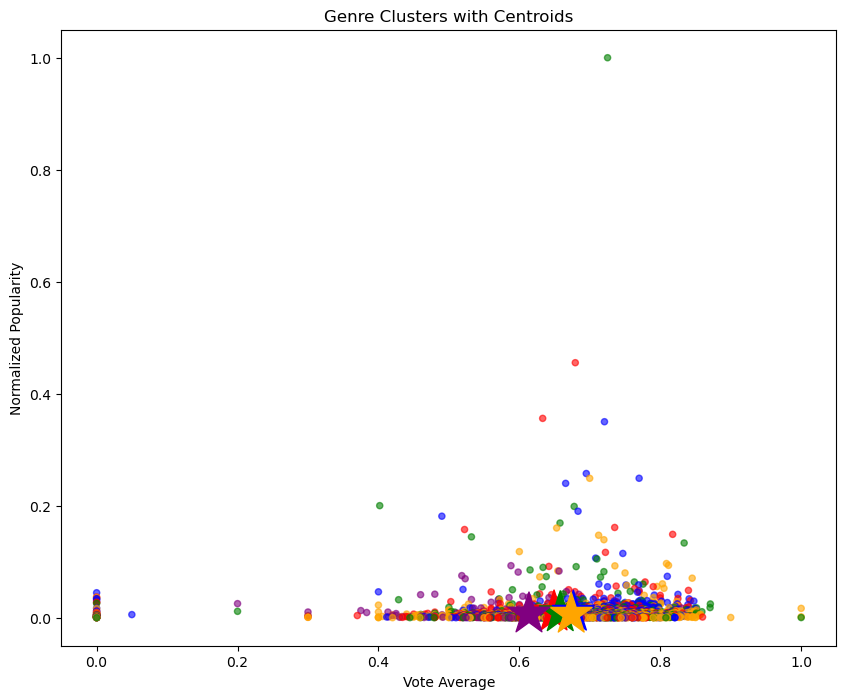

In [47]:
plt.figure(figsize=(10, 8))

# Map colors for different genre clusters
unique_clusters = tmdb_df['genre_cluster'].nunique()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'gray', 'olive', 'lime', 'teal', 'coral', 'indigo', 'violet', 'gold', 'navy'][:unique_clusters]

tmdb_df['colors'] = tmdb_df['genre_cluster'].map(lambda p: colors[p])

# Plot points
ax = tmdb_df.plot(kind='scatter',
                  x='vote_average_normalized',
                  y='popularity_normalized',
                  figsize=(10, 8),
                  c=tmdb_df['colors'],
                  marker='o',
                  alpha=0.6)

# Plot Centroids
genre_cluster_means.plot(kind='scatter',
                         x='vote_average_normalized',
                         y='popularity_normalized',
                         marker='*',
                         c=colors,
                         s=1000,
                         ax=ax)

# Set plot labels
plt.title('Genre Clusters with Centroids')
plt.xlabel('Vote Average')
plt.ylabel('Normalized Popularity')

# Set axis limits to zoom in
#plt.xlim(-0.2, 1)  
#plt.ylim(-0.2, 1)  

plt.show()


In [48]:
tmdb_df['colors'].value_counts()

colors
orange    848
green     650
blue      644
red       495
purple    363
Name: count, dtype: int64

finding best k value

In [49]:
# Inertia Scores
inertia_list = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(tfidf_matrix_genre)
    inertia_list.append(km.inertia_)


/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [50]:
inertia_list

[2412.657988420316,
 2121.207795786383,
 1869.4563983925727,
 1648.0039672397352,
 1471.3668891335847,
 1342.4300204138563,
 1243.7563342703615,
 1169.7284147449354,
 1113.7119686731305,
 1026.8433866770672]

In [51]:
# Silhouette Scores
silhouette_list = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(tfidf_matrix_genre)
    silhouette_list.append(silhouette_score(tfidf_matrix_genre, km.labels_))


/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

In [52]:
silhouette_list

[0.13604884731639882,
 0.17143436463659514,
 0.21053700402041553,
 0.24654364628147324,
 0.2528082179831329,
 0.26997102235816495,
 0.2792473115026671,
 0.27552231690130086,
 0.30714951955102426]

Text(0.5, 1.0, 'Silhouette Scores')

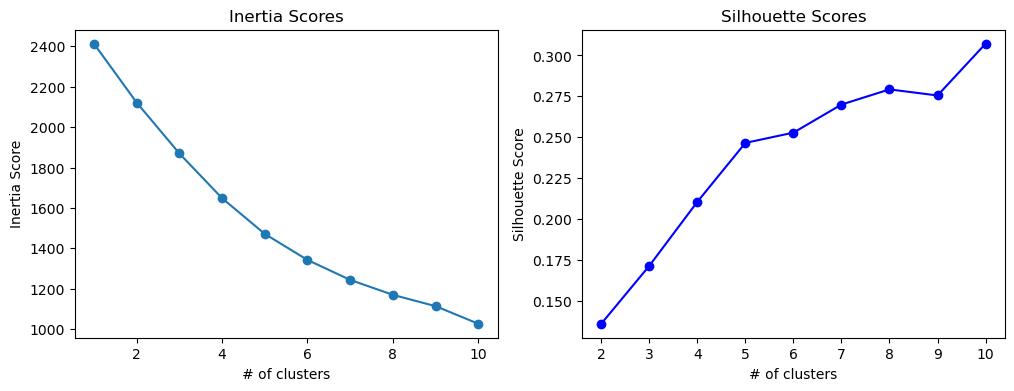

In [53]:
# Plotting Inertia Scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), inertia_list, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('Inertia Score')
plt.title('Inertia Scores')
# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_list, marker='o', color='blue')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

In [ ]:
# # Select only numeric columns
# numeric_columns = tmdb_df.select_dtypes(include=['number'])

# # Calculate correlation matrix
# correlation_matrix = numeric_columns.corr()

# # Display the correlation matrix as a table
# #correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
# correlation_matrix

/Users/aamad_000/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


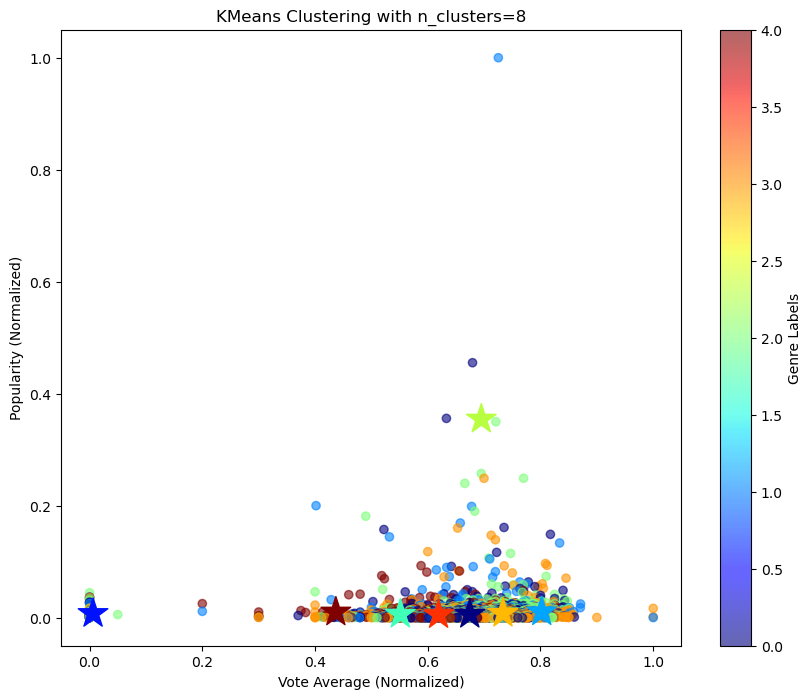

In [55]:
X_cluster = tmdb_df[['vote_average_normalized', 'popularity_normalized']]

# Create KMeans instance
km = KMeans(n_clusters=8, random_state=42)
km.fit(X_cluster)

# Get cluster labels and centroids
cluster_labels = km.labels_
centroids = km.cluster_centers_

# Plot the clusters
plt.figure(figsize=(10, 8))

# Scatter plot of data points with genre labels
scatter = plt.scatter(x='vote_average_normalized', y='popularity_normalized', c=tmdb_df['genre_cluster'], cmap='jet', data=tmdb_df, marker='o', alpha=0.6)

# Scatter plot of centroids with matching cluster colors
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=range(len(centroids)), cmap='jet', s=500, label='Centroids')  # Use 'range(len(centroids))' as the color values for centroids

# Set plot labels and title
plt.title('KMeans Clustering with n_clusters=8')
plt.xlabel('Vote Average (Normalized)')
plt.ylabel('Popularity (Normalized)')


# Add colorbar for genre labels
plt.colorbar(scatter, label='Genre Labels')




In [ ]:
tmdb_df['genre_cluster'].value_counts()

need to adjust kmeans number uptop

**gensim model (in work doesn't work at the moment)**

In [ ]:
# documents = [TaggedDocument(words=doc.split(), 
#                             tags=[str(i)]) for i, doc in enumerate(tmdb_df['preprocessed_overview'])]

In [ ]:
# #Train a Doc2Vec model
# doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
# doc2vec_model.build_vocab(documents)
# doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
# def recommend_based_on_user_input(user_input, model, data):
#     # Convert user input into a document embedding
#     user_embedding = model.infer_vector(user_input.split())

#     # Get similar movies using most_similar method
#     similar_movies = model.dv.most_similar([user_embedding], topn=len(model.dv))

#     # Extract movie indices from the similar_movies result
#     similar_movie_indices = [int(idx) for idx, _ in similar_movies]

#     # Get movie titles based on indices
#     recommended_movies = data.iloc[similar_movie_indices]['title'].tolist()

#     return recommended_movies

In [ ]:
# user_input = "soccer"
# recommended_movies = recommend_based_on_user_input(user_input, doc2vec_model, tmdb_df)
# print(recommended_movies[:7])

### 1.2.4 Data Visualization


**Deliverables:**

- Model Evaluation: Visualize the performance of different recommendation models using metrics such as precision, recall, and accuracy.
- Feature Importance: Gain insights into the importance of different features in the models through visualizations, aiding in model interpretation.
- User-Item Interaction: Visualize patterns in user-item interaction matrices to understand user preferences and item popularity.

---

scrap chatbot. Simplified what to do next is 1.) apply content-based genre clustering, 2.) visualizee that using centroids, silouhette, and inertia 3.) put it. all in streamlit app 4.) conclude